# Category Recomendation Random Forest
---

In [1]:
# imports
import json
import time
import random
import joblib
import pickle
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import top_k_accuracy_score, label_ranking_average_precision_score

In [2]:
data_path : str = "./dataset/"
models_path : str = "../web/models/local"
cities =  ["Burgos", "León", "Palencia", "Salamanca", "Valladolid"]


In [3]:
def construct_dataset(data_path: str) -> dict:

    # Abrimos el fichero de datos y lo convertimos a un dataframe
    with open(data_path, "r") as file:
        data = json.load(file)
    df = pd.json_normalize(data)

    # Contamos las apariciones de cada categoría
    category_count = df['Categoria'].value_counts()

    # Obtenemos dataframes para aquellas categorías con una única aparición
    single_categories = df[df['Categoria'].isin(category_count[category_count == 1].index)]
    single_categories_attr = single_categories.drop('Categoria', axis=1)
    single_categories_y = single_categories['Categoria']

    # Eliminamos las categorías con una única aparición del conjunto de datos
    df = df.drop(single_categories.index)

    # Separamos en dataframes de atributos y etiquetas
    df_attr = df.drop('Categoria', axis=1)
    df_y = df['Categoria']

    dataset = {
        "single_categories_X" : single_categories_attr,
        "single_categories_Y" : single_categories_y,
        "X" : df_attr,
        "Y" : df_y
    }

    return dataset  

In [4]:
def mean_reciprocal_rank(real_categories, category_probs, categories) -> float:
    mrr: float = 0
    sample_size = len(category_probs)

    for real, probs in zip(real_categories, category_probs):
        ranking: list = [[category, prob]
                         for category, prob in zip(categories, probs)]
        ranking.sort(key=lambda x: x[1], reverse=True)

        for index, prob in enumerate(ranking, start=1):
            if prob[0] == real:
                mrr += 1/index
                break

    return mrr/sample_size


In [5]:
def cross_validate_random_forest(dataset, k=5, **kwargs):

    # Creamos el objeto para KFold para hacer validación cruzada
    kf = KFold(n_splits=k, shuffle=True, random_state=random.randint(0, 100))

    # Dataframes de atributos y etiquetas
    X = dataset["X"]
    Y = dataset["Y"]

    # Dataframes de categorías con una única aparición
    single_categories_x = dataset["single_categories_X"]
    single_categories_y = dataset["single_categories_Y"]

    folds_mrr = []

    if "city" in kwargs:
        print(f"[{kwargs['city']}]")

    for n_fold, (train, test) in enumerate(kf.split(X), start=1):
        print(f">>> Fold: {n_fold}")
        classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)
        fold_time = time.time()

        # Añadimos al conjunto de datos de entrenamiento las categorías con una sola aparición
        df_train_x = pd.concat([X.iloc[train], single_categories_x])
        df_train_y = pd.concat([Y.iloc[train], single_categories_y])

        # Definimos conjunto de test
        df_test_x = X.iloc[test]
        df_test_y = Y.iloc[test]

        # Entrenamos el modelo
        classifier.fit(df_train_x, df_train_y)

        # Predicciones
        preds = classifier.predict_proba(df_test_x)

        # Calculamos el MRR
        mrr = mean_reciprocal_rank(df_test_y, preds, classifier.classes_)
        folds_mrr.append(mrr)
        print(f"> MRR: {mrr}")
        print(f"> Tiempo fold {n_fold}: {time.time() - fold_time :.1f} s")

    return np.average(folds_mrr)


In [6]:
def train_model(city):

    with open(f"{data_path}Q_{city}.json", "r") as file:
        data = json.load(file)
    df = pd.json_normalize(data)

    # Dataframes de atributos y etiquetas
    df_attr = df.drop('Categoria', axis=1)
    df_y = df['Categoria']

    ini_time = time.time()
    classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)

    classifier.fit(df_attr, df_y)
    print(f"> Tiempo train: {time.time() - ini_time :.1f} s")

    return classifier
    

In [7]:
cities_mrr = dict()
models_dict = dict()

for city in cities:
    dataset = construct_dataset(f"{data_path}Q_{city}.json")
    cities_mrr[city] = cross_validate_random_forest(dataset, city=city, k=100)
    models_dict[city] = train_model(city)


joblib.dump(models_dict,f"{models_path}/local.gz", compress=9)

[Burgos]
>>> Fold: 1
> MRR: 0.2473526535195571
> Tiempo fold 1: 12.7 s
>>> Fold: 2
> MRR: 0.2516627522212841
> Tiempo fold 2: 13.8 s
>>> Fold: 3
> MRR: 0.2438217347962827
> Tiempo fold 3: 18.4 s
>>> Fold: 4
> MRR: 0.3396942248618805
> Tiempo fold 4: 14.6 s
>>> Fold: 5
> MRR: 0.23648492461479673
> Tiempo fold 5: 12.9 s
>>> Fold: 6
> MRR: 0.28437151036895675
> Tiempo fold 6: 13.1 s
>>> Fold: 7
> MRR: 0.2514226605091916
> Tiempo fold 7: 13.2 s
>>> Fold: 8
> MRR: 0.2679035649384377
> Tiempo fold 8: 13.0 s
>>> Fold: 9
> MRR: 0.20712685746759868
> Tiempo fold 9: 12.4 s
>>> Fold: 10
> MRR: 0.23149092187202897
> Tiempo fold 10: 12.8 s
>>> Fold: 11
> MRR: 0.22882436740679996
> Tiempo fold 11: 12.2 s
>>> Fold: 12
> MRR: 0.3344824593126624
> Tiempo fold 12: 12.3 s
>>> Fold: 13
> MRR: 0.2419427167795884
> Tiempo fold 13: 12.5 s
>>> Fold: 14
> MRR: 0.24722122550120043
> Tiempo fold 14: 12.7 s
>>> Fold: 15
> MRR: 0.3355884469562993
> Tiempo fold 15: 12.4 s
>>> Fold: 16
> MRR: 0.20007477928515552
> T

['../web/models/local/local.gz']

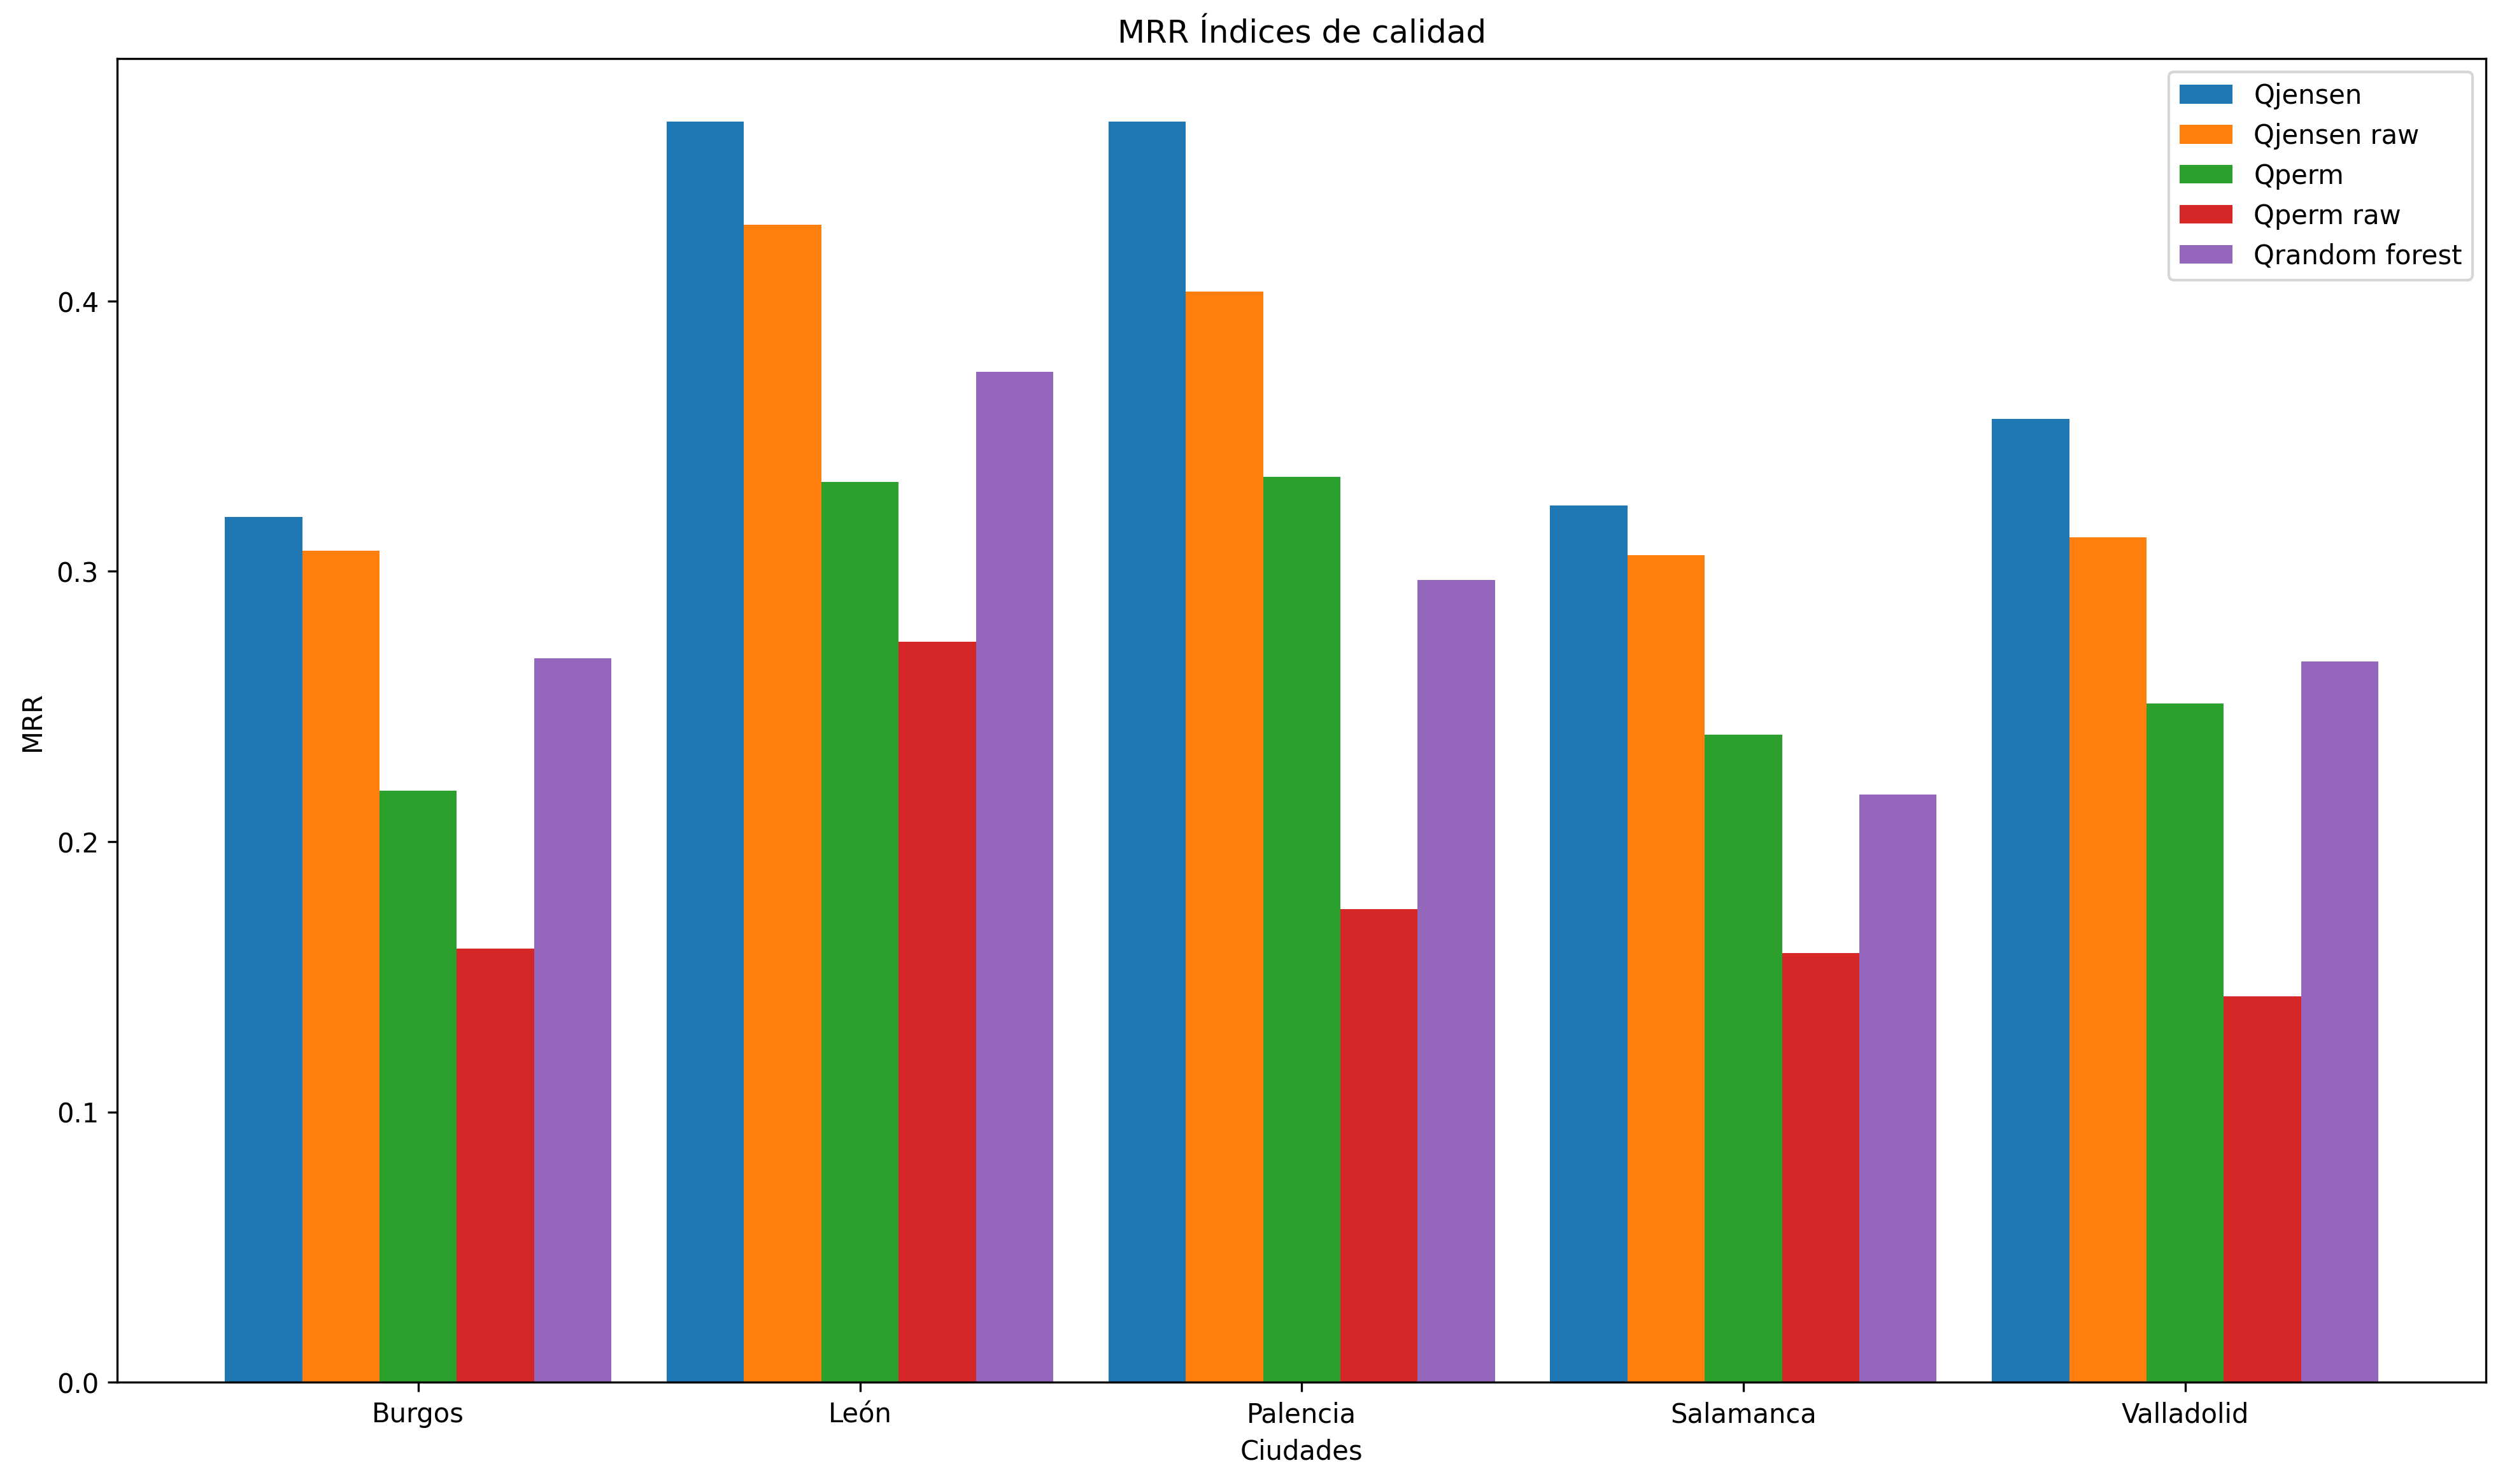

In [8]:
with open("./MRR.json", "r", encoding="utf-8") as read_json,  open("./CompleteMRR.json", "w", encoding="utf-8") as write_json:
    complete_mrr = json.load(read_json)
    for city in cities:
        complete_mrr[city]["Qrandom_forest"] = cities_mrr[city]
    json.dump(complete_mrr, write_json, indent=4, ensure_ascii=False)

    indexes = ["Qjensen", "Qjensen_raw",
               "Qperm", "Qperm_raw", "Qrandom_forest"]

    x_axis = np.arange(len(indexes))
    width = 0.175
    plt.figure(figsize=(16, 9), dpi=300)
    for i, q in enumerate(indexes):
        plt.bar(x_axis + width * i, [complete_mrr[city][q]
                for city in cities], width=width, label=q.replace("_", " "))
        # sep += 0.15
    plt.xlabel("Ciudades")
    plt.ylabel("MRR")
    plt.title("MRR Índices de calidad")
    plt.xticks(x_axis + width * 2, cities)
    plt.legend()
    plt.show()

In [9]:
# fig, axs = plt.subplots(3,2, figsize=(16,9), layout='tight')

# for ax, city_mrr in zip(axs.flat, complete_mrr.keys()):
#     ax.bar(complete_mrr[city_mrr].keys(),complete_mrr[city_mrr].values(), color='green')
#     ax.set_title(city_mrr)
#     ax.set_xlabel('Índices de calidad')
#     ax.set_ylabel('MRR')
# plt.show()